In [1]:
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import os
import sys
#
# from sklearn.preprocessing import KBinsDiscretizer
from joblib import Parallel, delayed
from tqdm import tqdm
# Ruta de entrada en el clúster
file_path = "datos/Land_and_Ocean_EqualArea.nc"

    # Abrir el dataset
data = xr.open_dataset(file_path)
latitudes = data['latitude'].values
longitudes = data['longitude'].values
temperature = data['temperature'].values

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
import community  
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from scipy.optimize import linear_sum_assignment
import matplotlib.colors as mcolors
import pandas as pd 
import plotly.graph_objects as go

# Lista de décadas que quieres visualizar, empezando desde 1850
decades = [str(year) for year in range(1850, 2020, 10)]

# Directorio donde están guardadas las matrices de información mutua
data_dir = "updated_decade_mutual_info2/updated_decade_mutual_info"

# Asegurarse de que el directorio existe
if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"El directorio '{data_dir}' no existe.")

# Inicializar listas para almacenar la modularidad y el número de comunidades por década
modularity_per_decade = []
communities_per_decade = []
available_decades = []
partitions_per_decade = {}

# Inicializar el mapeo global de comunidades a colores
global_community_color_map = {}
color_list = list(mcolors.CSS4_COLORS.keys())
color_index = 0  # Índice para asignar colores nuevos

# Definir la función para asignar etiquetas consistentes
def relabel_communities(prev_partition, current_partition):
    """
    Relabel communities in current_partition to match labels in prev_partition
    based on maximum node overlap.
    """
    import numpy as np
    from scipy.optimize import linear_sum_assignment

    # Obtener las comunidades únicas
    prev_communities = set(prev_partition.values())
    current_communities = set(current_partition.values())

    # Crear una matriz de costos (negativa de la superposición)
    cost_matrix = np.zeros((len(prev_communities), len(current_communities)))

    prev_comm_list = list(prev_communities)
    current_comm_list = list(current_communities)

    for i, prev_comm in enumerate(prev_comm_list):
        prev_nodes = {node for node, comm in prev_partition.items() if comm == prev_comm}
        for j, curr_comm in enumerate(current_comm_list):
            curr_nodes = {node for node, comm in current_partition.items() if comm == curr_comm}
            # El costo es negativo de la intersección (queremos maximizar la superposición)
            cost_matrix[i, j] = -len(prev_nodes & curr_nodes)

    # Resolver el problema de asignación
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Crear un mapeo de comunidades actuales a las etiquetas previas
    community_mapping = {}
    for i, j in zip(row_ind, col_ind):
        if -cost_matrix[i, j] > 0:
            community_mapping[current_comm_list[j]] = prev_comm_list[i]

    # Para las comunidades sin asignación, asignar nuevas etiquetas
    new_label = max(prev_communities) + 1 if prev_communities else 0
    for curr_comm in current_comm_list:
        if curr_comm not in community_mapping:
            community_mapping[curr_comm] = new_label
            new_label += 1

    # Crear una nueva partición con etiquetas actualizadas
    new_partition = {}
    for node, comm in current_partition.items():
        new_partition[node] = community_mapping[comm]

    return new_partition

previous_partition = None

# Almacenar la lista de nodos para el diagrama de Sankey
sankey_data = []

# Supongamos que ya tienes las listas de latitudes y longitudes
# latitudes = [...]
# longitudes = [...]

# Iterar sobre cada década y procesar la matriz de información mutua correspondiente
for decade in decades:
    # Ruta del archivo .npy para la década
    file_path = os.path.join(data_dir, f"updated_mutual_info_matrix_decade_{decade}.npy")
    
    # Verificar si el archivo existe
    if not os.path.isfile(file_path):
        print(f"Advertencia: El archivo para la década {decade} no se encontró en '{data_dir}'. Saltando esta década.")
        continue  # Saltar a la siguiente década
    
    # Cargar la matriz de información mutua
    corr_matrix = np.load(file_path)
    
    # Crear el grafo a partir de la matriz de información mutua
    G = nx.Graph()
    
    num_nodes = corr_matrix.shape[0]
    
    # Añadir nodos con sus atributos de latitud y longitud
    # Asegúrate de que latitudes y longitudes están definidas
    for i in range(num_nodes):
        G.add_node(i, pos=(longitudes[i], latitudes[i]))
    
    # Definir el umbral de información mutua para crear aristas
    mutual_info_threshold = 0.8  # Puedes ajustar este valor según tus necesidades
    
    # Añadir aristas basadas en el umbral de información mutua
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if np.isfinite(corr_matrix[i, j]) and corr_matrix[i, j] >= mutual_info_threshold:
                G.add_edge(i, j, weight=corr_matrix[i, j])
    
    # Verificar si hay nodos en el grafo
    if G.number_of_nodes() == 0:
        print(f"Advertencia: No hay nodos en el grafo para la década {decade}. Saltando esta década.")
        continue
    
    # Detectar comunidades usando el método de Louvain
    if G.number_of_edges() == 0:
        print(f"Advertencia: No se encontraron aristas para la década {decade}.")
        modularity_per_decade.append(np.nan)
        communities_per_decade.append(np.nan)
    else:
        partition = community.best_partition(G, weight='weight')
        
        # Si no es la primera década, reasignar etiquetas
        if previous_partition is not None:
            partition = relabel_communities(previous_partition, partition)
        else:
            # Ajustar etiquetas para que empiecen desde 0
            partition = {node: comm for node, comm in partition.items()}
        
        # Almacenar la partición actual para la siguiente iteración
        previous_partition = partition.copy()
        partitions_per_decade[decade] = partition
        
        # Calcular la modularidad
        modularity = community.modularity(partition, G, weight='weight')
        modularity_per_decade.append(modularity)
        available_decades.append(decade)
        
        # Contar el número de comunidades
        num_communities = len(set(partition.values()))
        communities_per_decade.append(num_communities)
        
        print(f"Década {decade}: Modularidad = {modularity:.4f}, Número de Comunidades = {num_communities}")
        
        # Actualizar el mapeo global de comunidades a colores
        for comm in set(partition.values()):
            if comm not in global_community_color_map:
                if color_index < len(color_list):
                    global_community_color_map[comm] = color_list[color_index]
                    color_index += 1
                else:
                    # Si nos quedamos sin colores, reutilizamos
                    global_community_color_map[comm] = color_list[color_index % len(color_list)]
                    color_index += 1
        
        # Asignar colores a los nodos usando el mapeo global
        node_colors = [global_community_color_map[partition[node]] for node in G.nodes()]
        
        # Visualizar la red geográfica con colores por comunidad
        plt.figure(figsize=(14, 10))  # Imagen más grande
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw_networkx_nodes(G, pos, node_size=30, node_color=node_colors, alpha=0.8)
        nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')
        plt.title(f"Red Geográfica de Información Mutua - Década {decade}s")
        plt.xlabel("Longitud")
        plt.ylabel("Latitud")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Almacenar datos para el diagrama de Sankey
        sankey_data.append({'decade': decade, 'partition': partition})

# Verificar si se calcularon modularidades y comunidades
if not modularity_per_decade:
    raise ValueError("No se calcularon modularidades ni número de comunidades para ninguna década.")

# Plotear la serie de tiempo de la modularidad por década
plt.figure(figsize=(12, 6))
plt.plot(available_decades, modularity_per_decade, marker='o', linestyle='-', color='b', label='Modularidad')
plt.title("Serie de Tiempo de la Modularidad por Década")
plt.xlabel("Década")
plt.ylabel("Modularidad")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plotear la serie de tiempo del número de comunidades por década
plt.figure(figsize=(12, 6))
plt.plot(available_decades, communities_per_decade, marker='s', linestyle='-', color='r', label='Número de Comunidades')
plt.title("Serie de Tiempo del Número de Comunidades por Década")
plt.xlabel("Década")
plt.ylabel("Número de Comunidades")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Generar diagramas de Sankey para cada cambio de década
for i in range(len(sankey_data) - 1):
    curr_decade = sankey_data[i]['decade']
    next_decade = sankey_data[i + 1]['decade']
    curr_partition = sankey_data[i]['partition']
    next_partition = sankey_data[i + 1]['partition']

    # Crear listas para las etiquetas y los flujos
    labels = []
    label_indices = {}
    index_counter = 0

    # Comunidades en la década actual
    curr_communities = set(curr_partition.values())
    for comm in curr_communities:
        label = f"{curr_decade}: Comunidad {comm}"
        label_indices[label] = index_counter
        labels.append(label)
        index_counter += 1

    # Comunidades en la siguiente década
    next_communities = set(next_partition.values())
    for comm in next_communities:
        label = f"{next_decade}: Comunidad {comm}"
        label_indices[label] = index_counter
        labels.append(label)
        index_counter += 1

    # Crear los flujos entre comunidades
    source = []
    target = []
    value = []

    # Crear un DataFrame para facilitar el conteo
    df = pd.DataFrame({
        'node': list(curr_partition.keys()),
        'curr_comm': [curr_partition[node] for node in curr_partition.keys()],
        'next_comm': [next_partition.get(node, -1) for node in curr_partition.keys()]
    })

    # Agrupar y contar los flujos
    group = df.groupby(['curr_comm', 'next_comm']).size().reset_index(name='count')

    for _, row in group.iterrows():
        curr_label = f"{curr_decade}: Comunidad {int(row['curr_comm'])}"
        next_label = f"{next_decade}: Comunidad {int(row['next_comm'])}"
        source.append(label_indices[curr_label])
        target.append(label_indices[next_label])
        value.append(row['count'])

    # Crear el diagrama de Sankey para esta transición
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
        ),
        link=dict(
            source=source,
            target=target,
            value=value
        ))])

    fig.update_layout(title_text=f"Flujo de Comunidades de {curr_decade}s a {next_decade}s", font_size=10)
    fig.show()


Advertencia: El archivo para la década 1850 no se encontró en 'updated_decade_mutual_info2/updated_decade_mutual_info'. Saltando esta década.
Década 1860: Modularidad = 0.3631, Número de Comunidades = 94


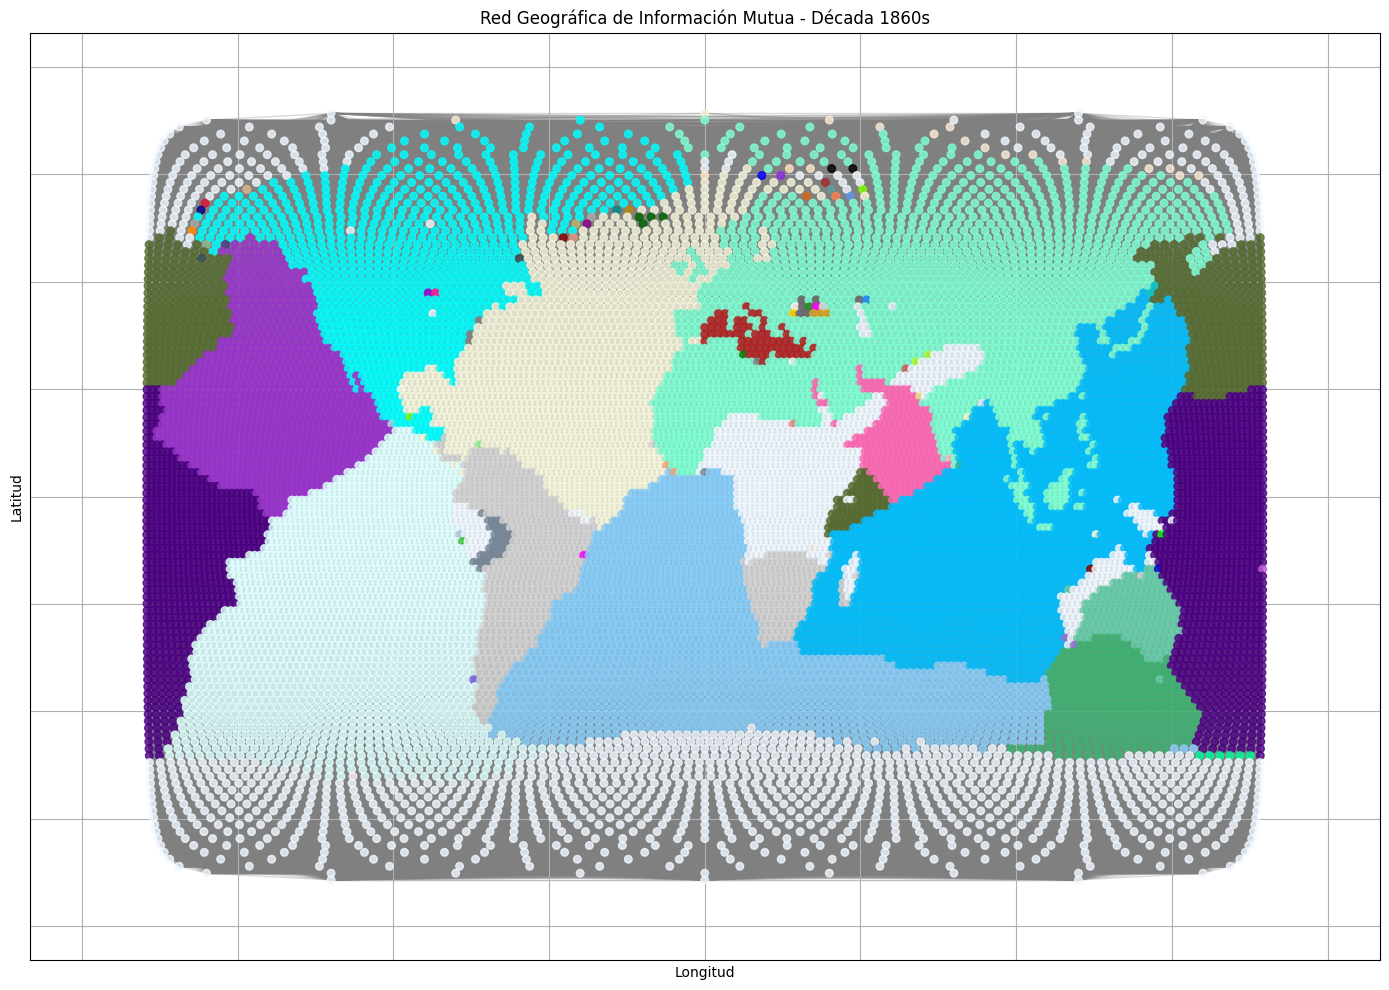

Década 1870: Modularidad = 0.5583, Número de Comunidades = 62


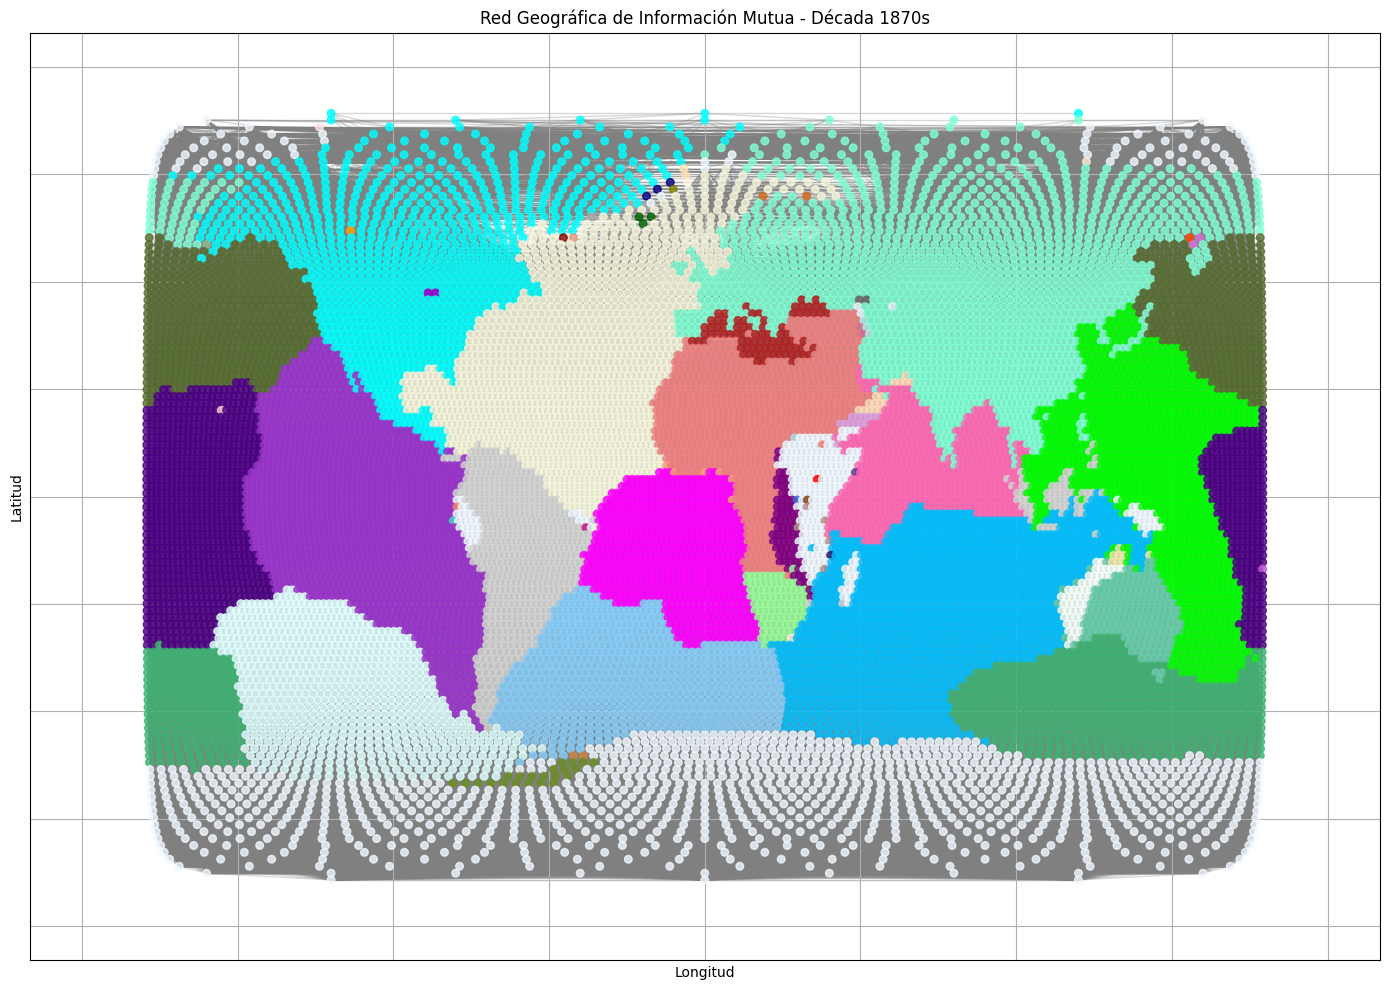

Transición 1860-1870:
  ARI = 0.5555, NMI = 0.7304
  Nodos en la misma comunidad: 10148 de 15984 (63.49%)


KeyboardInterrupt: 

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
import community  # Asegúrate de tener instalado el paquete python-louvain
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from scipy.optimize import linear_sum_assignment
import matplotlib.colors as mcolors
import pandas as pd  # Para cargar 'data' usando pandas
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import plotly.graph_objects as go

# Lista de décadas que quieres visualizar, empezando desde 1850
decades = [str(year) for year in range(1850, 2020, 10)]

# Directorio donde están guardadas las matrices de información mutua
data_dir = "updated_decade_mutual_info2/updated_decade_mutual_info"

# Asegurarse de que el directorio existe
if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"El directorio '{data_dir}' no existe.")

# Inicializar listas para almacenar la modularidad y el número de comunidades por década
modularity_per_decade = []
communities_per_decade = []
available_decades = []
partitions_per_decade = {}

# Inicializar el mapeo global de comunidades a colores
global_community_color_map = {}
color_list = list(mcolors.CSS4_COLORS.keys())
color_index = 0  # Índice para asignar colores nuevos

# Definir la función para asignar etiquetas consistentes
def relabel_communities(prev_partition, current_partition):
    """
    Relabel communities in current_partition to match labels in prev_partition
    based on maximum node overlap.
    """
    import numpy as np
    from scipy.optimize import linear_sum_assignment

    # Obtener las comunidades únicas
    prev_communities = set(prev_partition.values())
    current_communities = set(current_partition.values())

    # Crear una matriz de costos (negativa de la superposición)
    cost_matrix = np.zeros((len(prev_communities), len(current_communities)))

    prev_comm_list = list(prev_communities)
    current_comm_list = list(current_communities)

    for i, prev_comm in enumerate(prev_comm_list):
        prev_nodes = {node for node, comm in prev_partition.items() if comm == prev_comm}
        for j, curr_comm in enumerate(current_comm_list):
            curr_nodes = {node for node, comm in current_partition.items() if comm == curr_comm}
            # El costo es negativo de la intersección (queremos maximizar la superposición)
            cost_matrix[i, j] = -len(prev_nodes & curr_nodes)

    # Resolver el problema de asignación
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Crear un mapeo de comunidades actuales a las etiquetas previas
    community_mapping = {}
    for i, j in zip(row_ind, col_ind):
        if -cost_matrix[i, j] > 0:
            community_mapping[current_comm_list[j]] = prev_comm_list[i]

    # Para las comunidades sin asignación, asignar nuevas etiquetas
    new_label = max(prev_communities) + 1 if prev_communities else 0
    for curr_comm in current_comm_list:
        if curr_comm not in community_mapping:
            community_mapping[curr_comm] = new_label
            new_label += 1

    # Crear una nueva partición con etiquetas actualizadas
    new_partition = {}
    for node, comm in current_partition.items():
        new_partition[node] = community_mapping[comm]

    return new_partition

previous_partition = None

# Almacenar la lista de nodos para el diagrama de Sankey
sankey_data = []


# Inicializar listas para almacenar las métricas de similitud y nodos constantes
ari_scores = []
nmi_scores = []
same_community_counts = []
same_community_percentages = []
transition_decades = []

# Iterar sobre cada década y procesar la matriz de información mutua correspondiente
for decade in decades:
    # Ruta del archivo .npy para la década
    file_path = os.path.join(data_dir, f"updated_mutual_info_matrix_decade_{decade}.npy")
    
    # Verificar si el archivo existe
    if not os.path.isfile(file_path):
        print(f"Advertencia: El archivo para la década {decade} no se encontró en '{data_dir}'. Saltando esta década.")
        continue  # Saltar a la siguiente década
    
    # Cargar la matriz de información mutua
    corr_matrix = np.load(file_path)
    
    # Crear el grafo a partir de la matriz de información mutua
    G = nx.Graph()
    
    num_nodes = corr_matrix.shape[0]
    
    # Añadir nodos con sus atributos de latitud y longitud
    # Asegúrate de que latitudes y longitudes están definidas
    for i in range(num_nodes):
        G.add_node(i, pos=(longitudes[i], latitudes[i]))
    
    # Definir el umbral de información mutua para crear aristas
    mutual_info_threshold = 0.8  # Puedes ajustar este valor según tus necesidades
    
    # Añadir aristas basadas en el umbral de información mutua
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if np.isfinite(corr_matrix[i, j]) and corr_matrix[i, j] >= mutual_info_threshold:
                G.add_edge(i, j, weight=corr_matrix[i, j])
    
    # Verificar si hay nodos en el grafo
    if G.number_of_nodes() == 0:
        print(f"Advertencia: No hay nodos en el grafo para la década {decade}. Saltando esta década.")
        continue
    
    # Detectar comunidades usando el método de Louvain
    if G.number_of_edges() == 0:
        print(f"Advertencia: No se encontraron aristas para la década {decade}.")
        modularity_per_decade.append(np.nan)
        communities_per_decade.append(np.nan)
    else:
        partition = community.best_partition(G, weight='weight')
        
        # Si no es la primera década, reasignar etiquetas
        if previous_partition is not None:
            partition = relabel_communities(previous_partition, partition)
        else:
            # Ajustar etiquetas para que empiecen desde 0
            partition = {node: comm for node, comm in partition.items()}
        
        # Almacenar la partición actual para la siguiente iteración
        partitions_per_decade[decade] = partition.copy()
        
        # Calcular la modularidad
        modularity = community.modularity(partition, G, weight='weight')
        modularity_per_decade.append(modularity)
        available_decades.append(decade)
        
        # Contar el número de comunidades
        num_communities = len(set(partition.values()))
        communities_per_decade.append(num_communities)
        
        print(f"Década {decade}: Modularidad = {modularity:.4f}, Número de Comunidades = {num_communities}")
        
        # Actualizar el mapeo global de comunidades a colores
        for comm in set(partition.values()):
            if comm not in global_community_color_map:
                if color_index < len(color_list):
                    global_community_color_map[comm] = color_list[color_index]
                    color_index += 1
                else:
                    # Si nos quedamos sin colores, reutilizamos
                    global_community_color_map[comm] = color_list[color_index % len(color_list)]
                    color_index += 1
        
        # Asignar colores a los nodos usando el mapeo global
        node_colors = [global_community_color_map[partition[node]] for node in G.nodes()]
        
        # Visualizar la red geográfica con colores por comunidad
        plt.figure(figsize=(14, 10))  # Imagen más grande
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw_networkx_nodes(G, pos, node_size=30, node_color=node_colors, alpha=0.8)
        nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')
        plt.title(f"Red Geográfica de Información Mutua - Década {decade}s")
        plt.xlabel("Longitud")
        plt.ylabel("Latitud")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Calcular similitud con la partición anterior
        if previous_partition is not None:
            # Asegurarse de que los nodos estén ordenados de la misma manera
            nodes = sorted(partition.keys())
            labels_current = [partition[node] for node in nodes]
            labels_previous = [previous_partition[node] for node in nodes]
            
            # Calcular ARI y NMI
            ari = adjusted_rand_score(labels_previous, labels_current)
            nmi = normalized_mutual_info_score(labels_previous, labels_current)
            ari_scores.append(ari)
            nmi_scores.append(nmi)
            transition_decades.append(f"{available_decades[-2]}-{decade}")
            
            # Calcular el número de nodos que permanecen en la misma comunidad
            same_community_count = sum(1 for i in range(len(nodes)) if labels_current[i] == labels_previous[i])
            same_community_percentage = same_community_count / len(nodes) * 100
            same_community_counts.append(same_community_count)
            same_community_percentages.append(same_community_percentage)
            
            print(f"Transición {available_decades[-2]}-{decade}:")
            print(f"  ARI = {ari:.4f}, NMI = {nmi:.4f}")
            print(f"  Nodos en la misma comunidad: {same_community_count} de {len(nodes)} ({same_community_percentage:.2f}%)")
        
        # Almacenar datos para el diagrama de Sankey
        sankey_data.append({'decade': decade, 'partition': partition})
        
        # Actualizar la partición anterior
        previous_partition = partition.copy()

# Verificar si se calcularon modularidades y comunidades
if not modularity_per_decade:
    raise ValueError("No se calcularon modularidades ni número de comunidades para ninguna década.")

# Plotear la serie de tiempo de la modularidad por década
plt.figure(figsize=(12, 6))
plt.plot(available_decades, modularity_per_decade, marker='o', linestyle='-', color='b', label='Modularidad')
plt.title("Serie de Tiempo de la Modularidad por Década")
plt.xlabel("Década")
plt.ylabel("Modularidad")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plotear la serie de tiempo del número de comunidades por década
plt.figure(figsize=(12, 6))
plt.plot(available_decades, communities_per_decade, marker='s', linestyle='-', color='r', label='Número de Comunidades')
plt.title("Serie de Tiempo del Número de Comunidades por Década")
plt.xlabel("Década")
plt.ylabel("Número de Comunidades")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plotear las métricas de similitud entre décadas
plt.figure(figsize=(12, 6))
plt.plot(transition_decades, ari_scores, marker='o', linestyle='-', color='g', label='ARI')
plt.plot(transition_decades, nmi_scores, marker='s', linestyle='-', color='m', label='NMI')
plt.title("Similitud de Comunidades entre Décadas Consecutivas")
plt.xlabel("Transición de Décadas")
plt.ylabel("Similitud")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plotear el número y porcentaje de nodos que permanecen en la misma comunidad
plt.figure(figsize=(12, 6))
plt.plot(transition_decades, same_community_counts, marker='o', linestyle='-', color='c', label='Nodos Constantes')
plt.title("Número de Nodos que Permanece en la Misma Comunidad entre Décadas")
plt.xlabel("Transición de Décadas")
plt.ylabel("Número de Nodos")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(transition_decades, same_community_percentages, marker='s', linestyle='-', color='y', label='Porcentaje de Nodos Constantes')
plt.title("Porcentaje de Nodos que Permanece en la Misma Comunidad entre Décadas")
plt.xlabel("Transición de Décadas")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Generar diagramas de Sankey para cada cambio de década
for i in range(len(sankey_data) - 1):
    curr_decade = sankey_data[i]['decade']
    next_decade = sankey_data[i + 1]['decade']
    curr_partition = sankey_data[i]['partition']
    next_partition = sankey_data[i + 1]['partition']

    # Crear listas para las etiquetas y los flujos
    labels = []
    label_indices = {}
    index_counter = 0

    # Comunidades en la década actual
    curr_communities = set(curr_partition.values())
    for comm in curr_communities:
        label = f"{curr_decade}: Comunidad {comm}"
        label_indices[label] = index_counter
        labels.append(label)
        index_counter += 1

    # Comunidades en la siguiente década
    next_communities = set(next_partition.values())
    for comm in next_communities:
        label = f"{next_decade}: Comunidad {comm}"
        label_indices[label] = index_counter
        labels.append(label)
        index_counter += 1

    # Crear los flujos entre comunidades
    source = []
    target = []
    value = []

    # Crear un DataFrame para facilitar el conteo
    df = pd.DataFrame({
        'node': list(curr_partition.keys()),
        'curr_comm': [curr_partition[node] for node in curr_partition.keys()],
        'next_comm': [next_partition.get(node, -1) for node in curr_partition.keys()]
    })

    # Agrupar y contar los flujos
    group = df.groupby(['curr_comm', 'next_comm']).size().reset_index(name='count')

    for _, row in group.iterrows():
        curr_label = f"{curr_decade}: Comunidad {int(row['curr_comm'])}"
        next_label = f"{next_decade}: Comunidad {int(row['next_comm'])}"
        source.append(label_indices[curr_label])
        target.append(label_indices[next_label])
        value.append(row['count'])

    # Crear el diagrama de Sankey para esta transición
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
        ),
        link=dict(
            source=source,
            target=target,
            value=value
        ))])

    fig.update_layout(title_text=f"Flujo de Comunidades de {curr_decade}s a {next_decade}s", font_size=10)
    fig.show()


In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
import community  # Asegúrate de tener instalado el paquete python-louvain
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from scipy.optimize import linear_sum_assignment
import matplotlib.colors as mcolors
import pandas as pd  # Para cargar 'data' usando pandas
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import plotly.graph_objects as go

# Lista de décadas que quieres visualizar, empezando desde 1850
decades = [str(year) for year in range(1850, 2020, 10)]

# Directorio donde están guardadas las matrices de información mutua
data_dir = "updated_decade_mutual_info2/updated_decade_mutual_info"

# Asegurarse de que el directorio existe
if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"El directorio '{data_dir}' no existe.")

# Inicializar listas para almacenar la modularidad y el número de comunidades por década
modularity_per_decade = []
communities_per_decade = []
available_decades = []
partitions_per_decade = {}

# Inicializar el mapeo global de comunidades a colores
global_community_color_map = {}
color_list = list(mcolors.CSS4_COLORS.keys())
color_index = 0  # Índice para asignar colores nuevos

# Definir la función para asignar etiquetas consistentes
def relabel_communities(prev_partition, current_partition):
    """
    Relabel communities in current_partition to match labels in prev_partition
    based on maximum node overlap.
    """
    import numpy as np
    from scipy.optimize import linear_sum_assignment

    # Obtener las comunidades únicas
    prev_communities = set(prev_partition.values())
    current_communities = set(current_partition.values())

    # Crear una matriz de costos (negativa de la superposición)
    cost_matrix = np.zeros((len(prev_communities), len(current_communities)))

    prev_comm_list = list(prev_communities)
    current_comm_list = list(current_communities)

    for i, prev_comm in enumerate(prev_comm_list):
        prev_nodes = {node for node, comm in prev_partition.items() if comm == prev_comm}
        for j, curr_comm in enumerate(current_comm_list):
            curr_nodes = {node for node, comm in current_partition.items() if comm == curr_comm}
            # El costo es negativo de la intersección (queremos maximizar la superposición)
            cost_matrix[i, j] = -len(prev_nodes & curr_nodes)

    # Resolver el problema de asignación
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Crear un mapeo de comunidades actuales a las etiquetas previas
    community_mapping = {}
    for i, j in zip(row_ind, col_ind):
        if -cost_matrix[i, j] > 0:
            community_mapping[current_comm_list[j]] = prev_comm_list[i]

    # Para las comunidades sin asignación, asignar nuevas etiquetas
    new_label = max(prev_communities) + 1 if prev_communities else 0
    for curr_comm in current_comm_list:
        if curr_comm not in community_mapping:
            community_mapping[curr_comm] = new_label
            new_label += 1

    # Crear una nueva partición con etiquetas actualizadas
    new_partition = {}
    for node, comm in current_partition.items():
        new_partition[node] = community_mapping[comm]

    return new_partition

previous_partition = None

# Almacenar la lista de nodos para el diagrama de Sankey
sankey_data = []

# Inicializar listas para almacenar las métricas de similitud y nodos constantes
ari_scores = []
nmi_scores = []
same_community_counts = []
same_community_percentages = []
transition_decades = []

# Asegúrate de que las listas 'latitudes' y 'longitudes' están definidas
# Deben contener las coordenadas geográficas de los nodos
# Por ejemplo:
# latitudes = [...]
# longitudes = [...]

# Iterar sobre cada década y procesar la matriz de información mutua correspondiente
for decade in decades:
    # Ruta del archivo .npy para la década
    file_path = os.path.join(data_dir, f"updated_mutual_info_matrix_decade_{decade}.npy")
    
    # Verificar si el archivo existe
    if not os.path.isfile(file_path):
        print(f"Advertencia: El archivo para la década {decade} no se encontró en '{data_dir}'. Saltando esta década.")
        continue  # Saltar a la siguiente década
    
    # Cargar la matriz de información mutua
    corr_matrix = np.load(file_path)
    
    # Crear el grafo a partir de la matriz de información mutua
    G = nx.Graph()
    
    num_nodes = corr_matrix.shape[0]
    
    # Añadir nodos con sus atributos de latitud y longitud
    # Asegúrate de que 'latitudes' y 'longitudes' están definidas
    for i in range(num_nodes):
        G.add_node(i, pos=(longitudes[i], latitudes[i]))
    
    # Definir el umbral de información mutua para crear aristas
    mutual_info_threshold = 0.8  # Puedes ajustar este valor según tus necesidades
    
    # Añadir aristas basadas en el umbral de información mutua
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if np.isfinite(corr_matrix[i, j]) and corr_matrix[i, j] >= mutual_info_threshold:
                G.add_edge(i, j, weight=corr_matrix[i, j])
    
    # Verificar si hay nodos en el grafo
    if G.number_of_nodes() == 0:
        print(f"Advertencia: No hay nodos en el grafo para la década {decade}. Saltando esta década.")
        continue
    
    # Detectar comunidades usando el método de Louvain
    if G.number_of_edges() == 0:
        print(f"Advertencia: No se encontraron aristas para la década {decade}.")
        modularity_per_decade.append(np.nan)
        communities_per_decade.append(np.nan)
    else:
        partition = community.best_partition(G, weight='weight')
        
        # Si no es la primera década, reasignar etiquetas
        if previous_partition is not None:
            partition = relabel_communities(previous_partition, partition)
        else:
            # Ajustar etiquetas para que empiecen desde 0
            partition = {node: comm for node, comm in partition.items()}
        
        # Almacenar la partición actual para la siguiente iteración
        partitions_per_decade[decade] = partition.copy()
        
        # Calcular la modularidad
        modularity = community.modularity(partition, G, weight='weight')
        modularity_per_decade.append(modularity)
        available_decades.append(decade)
        
        # Contar el número de comunidades
        num_communities = len(set(partition.values()))
        communities_per_decade.append(num_communities)
        
        print(f"Década {decade}: Modularidad = {modularity:.4f}, Número de Comunidades = {num_communities}")
        
        # Actualizar el mapeo global de comunidades a colores
        for comm in set(partition.values()):
            if comm not in global_community_color_map:
                if color_index < len(color_list):
                    global_community_color_map[comm] = color_list[color_index]
                    color_index += 1
                else:
                    # Si nos quedamos sin colores, reutilizamos
                    global_community_color_map[comm] = color_list[color_index % len(color_list)]
                    color_index += 1
        
        # Asignar colores a los nodos usando el mapeo global
        node_colors = [global_community_color_map[partition[node]] for node in G.nodes()]
        
        # Visualizar la red geográfica con colores por comunidad (sin etiquetas)
        plt.figure(figsize=(14, 10))  # Imagen más grande
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw_networkx_nodes(G, pos, node_size=30, node_color=node_colors, alpha=0.8)
        nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')
        
        plt.title(f"Red Geográfica de Información Mutua - Década {decade}s")
        plt.xlabel("Longitud")
        plt.ylabel("Latitud")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Calcular similitud con la partición anterior
        if previous_partition is not None:
            # Asegurarse de que los nodos estén ordenados de la misma manera
            nodes = sorted(partition.keys())
            labels_current = [partition[node] for node in nodes]
            labels_previous = [previous_partition[node] for node in nodes]
            
            # Calcular ARI y NMI
            ari = adjusted_rand_score(labels_previous, labels_current)
            nmi = normalized_mutual_info_score(labels_previous, labels_current)
            ari_scores.append(ari)
            nmi_scores.append(nmi)
            transition_decades.append(f"{available_decades[-2]}-{decade}")
            
            # Calcular el número de nodos que permanecen en la misma comunidad
            same_community_count = sum(1 for i in range(len(nodes)) if labels_current[i] == labels_previous[i])
            same_community_percentage = same_community_count / len(nodes) * 100
            same_community_counts.append(same_community_count)
            same_community_percentages.append(same_community_percentage)
            
            print(f"Transición {available_decades[-2]}-{decade}:")
            print(f"  ARI = {ari:.4f}, NMI = {nmi:.4f}")
            print(f"  Nodos en la misma comunidad: {same_community_count} de {len(nodes)} ({same_community_percentage:.2f}%)")
        
        # Almacenar datos para el diagrama de Sankey
        sankey_data.append({'decade': decade, 'partition': partition})
        
        # Actualizar la partición anterior
        previous_partition = partition.copy()

# El resto del código permanece igual, incluyendo la generación de los diagramas de Sankey
# y el análisis de los nodos que se mantienen constantes a lo largo del tiempo.

# Por ejemplo, si deseas generar los diagramas de Sankey para comunidades específicas:
selected_communities = [0]  # Reemplaza con las comunidades que quieres ver

# Generar diagramas de Sankey para cada cambio de década, enfocándose en comunidades seleccionadas
for i in range(len(sankey_data) - 1):
    curr_decade = sankey_data[i]['decade']
    next_decade = sankey_data[i + 1]['decade']
    curr_partition = sankey_data[i]['partition']
    next_partition = sankey_data[i + 1]['partition']

    # Filtrar los nodos para incluir solo aquellos en las comunidades seleccionadas
    nodes_in_selected_communities = [node for node in curr_partition if curr_partition[node] in selected_communities]

    if not nodes_in_selected_communities:
        print(f"No hay nodos en las comunidades seleccionadas para la transición {curr_decade}-{next_decade}.")
        continue

    # Crear listas para las etiquetas y los flujos
    labels = []
    label_indices = {}
    index_counter = 0

    # Comunidades en la década actual (solo las seleccionadas)
    curr_communities = set([curr_partition[node] for node in nodes_in_selected_communities])

    # Comunidades en la siguiente década (a las que van los nodos seleccionados)
    next_communities = set([next_partition.get(node, -1) for node in nodes_in_selected_communities])

    # Crear etiquetas para comunidades de la década actual
    for comm in curr_communities:
        label = f"{curr_decade}: Comunidad {comm}"
        label_indices[label] = index_counter
        labels.append(label)
        index_counter += 1

    # Crear etiquetas para comunidades de la siguiente década
    for comm in next_communities:
        label = f"{next_decade}: Comunidad {comm}"
        label_indices[label] = index_counter
        labels.append(label)
        index_counter += 1

    # Crear los flujos entre comunidades
    source = []
    target = []
    value = []

    # Crear un DataFrame para facilitar el conteo
    df = pd.DataFrame({
        'node': nodes_in_selected_communities,
        'curr_comm': [curr_partition[node] for node in nodes_in_selected_communities],
        'next_comm': [next_partition.get(node, -1) for node in nodes_in_selected_communities]
    })

    # Agrupar y contar los flujos
    group = df.groupby(['curr_comm', 'next_comm']).size().reset_index(name='count')

    for _, row in group.iterrows():
        curr_label = f"{curr_decade}: Comunidad {int(row['curr_comm'])}"
        next_label = f"{next_decade}: Comunidad {int(row['next_comm'])}"
        source.append(label_indices[curr_label])
        target.append(label_indices[next_label])
        value.append(row['count'])

    # Crear el diagrama de Sankey para esta transición
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
        ),
        link=dict(
            source=source,
            target=target,
            value=value
        ))])

    fig.update_layout(title_text=f"Flujo de Comunidad(s) Seleccionada(s) de {curr_decade}s a {next_decade}s", font_size=10)
    fig.show()


Advertencia: El archivo para la década 1850 no se encontró en 'updated_decade_mutual_info2/updated_decade_mutual_info'. Saltando esta década.
Década 1860: Modularidad = 0.3631, Número de Comunidades = 95


KeyboardInterrupt: 

In [ ]:
# Crear un diccionario para almacenar la asignación de comunidades por nodo en cada década
node_communities_over_time = {}

# Obtener la lista ordenada de décadas disponibles
decades_in_order = sorted(partitions_per_decade.keys())

# Inicializar el diccionario con listas vacías para cada nodo
all_nodes = set()
for decade in decades_in_order:
    all_nodes.update(partitions_per_decade[decade].keys())

for node in all_nodes:
    node_communities_over_time[node] = []

# Llenar el diccionario con las asignaciones de comunidades
for decade in decades_in_order:
    partition = partitions_per_decade[decade]
    for node in all_nodes:
        # Algunos nodos pueden no estar presentes en todas las décadas
        # Usaremos None para indicar ausencia
        community = partition.get(node, None)
        node_communities_over_time[node].append(community)

# Definir el número mínimo de décadas consecutivas en las que el nodo debe permanecer en la misma comunidad
min_consecutive_decades = 3  # Puedes ajustar este valor

nodes_constant_community_min = []

for node, communities in node_communities_over_time.items():
    # Crear una lista de pares (decade_index, community)
    # Ignorar las décadas en las que el nodo está ausente (community is None)
    present_decades = [(i, comm) for i, comm in enumerate(communities) if comm is not None]
    
    if len(present_decades) < min_consecutive_decades:
        continue  # No hay suficientes décadas en las que el nodo está presente
    
    # Ahora, buscamos secuencias de al menos 'min_consecutive_decades' décadas consecutivas en la misma comunidad
    max_consecutive = 1
    current_consecutive = 1
    for i in range(1, len(present_decades)):
        # Verificar si las décadas son consecutivas
        if present_decades[i][0] == present_decades[i-1][0] + 1:
            # Verificar si la comunidad es la misma
            if present_decades[i][1] == present_decades[i-1][1]:
                current_consecutive += 1
                if current_consecutive >= min_consecutive_decades:
                    nodes_constant_community_min.append(node)
                    break  # Ya cumple, no necesitamos seguir
            else:
                current_consecutive = 1  # Reiniciar contador
        else:
            current_consecutive = 1  # Reiniciar contador

# Mostrar resultados
print(f"Número de nodos que permanecen en la misma comunidad al menos {min_consecutive_decades} décadas consecutivas: {len(nodes_constant_community_min)}")

# Opcional: Mostrar los nodos y sus comunidades
for node in nodes_constant_community_min:
    # Obtener la comunidad durante la secuencia
    communities = node_communities_over_time[node]
    # Encontrar la comunidad en la que estuvo durante la secuencia de décadas
    for i in range(len(communities) - min_consecutive_decades + 1):
        sequence = communities[i:i+min_consecutive_decades]
        if None not in sequence and len(set(sequence)) == 1:
            community = sequence[0]
            print(f"Nodo {node}: Comunidad {community}")
            break

# Visualizar los nodos constantes en el mapa
plt.figure(figsize=(14, 10))
G_full = nx.Graph()

# Añadir nodos con posiciones
for node in nodes_constant_community_min:
    G_full.add_node(node, pos=(longitudes[node], latitudes[node]))

# Asignar colores basados en la comunidad (por ejemplo, la primera comunidad encontrada)
node_colors = []
for node in G_full.nodes():
    communities = node_communities_over_time[node]
    # Encontrar la comunidad en la que estuvo durante la secuencia de décadas
    for i in range(len(communities) - min_consecutive_decades + 1):
        sequence = communities[i:i+min_consecutive_decades]
        if None not in sequence and len(set(sequence)) == 1:
            community = sequence[0]
            break
    node_colors.append(global_community_color_map[community])

# Obtener posiciones
pos = nx.get_node_attributes(G_full, 'pos')

# Dibujar nodos
nx.draw_networkx_nodes(G_full, pos, node_size=50, node_color=node_colors, alpha=0.8)

plt.title(f"Nodos que Permanecen en la Misma Comunidad al Menos {min_consecutive_decades} Décadas Consecutivas")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Crear un diccionario para almacenar la asignación de comunidades por nodo en cada década
node_communities_over_time = {}

# Obtener la lista ordenada de décadas disponibles
decades_in_order = sorted(partitions_per_decade.keys())

# Inicializar el diccionario con listas vacías para cada nodo
all_nodes = set()
for decade in decades_in_order:
    all_nodes.update(partitions_per_decade[decade].keys())

for node in all_nodes:
    node_communities_over_time[node] = []

# Llenar el diccionario con las asignaciones de comunidades
for decade in decades_in_order:
    partition = partitions_per_decade[decade]
    for node in all_nodes:

        community = partition.get(node, None)
        node_communities_over_time[node].append(community)

# Definir el número mínimo de décadas en las que el nodo debe cambiar de comunidad
min_decades_with_changes = 6 # Puedes ajustar este valor

nodes_with_changes = []

for node, communities in node_communities_over_time.items():
    # Crear una lista de comunidades ignorando décadas en las que el nodo está ausente (community is None)
    filtered_communities = [comm for comm in communities if comm is not None]
    
    # Si hay menos de dos décadas presentes, no puede haber cambio de comunidad
    if len(filtered_communities) < 2:
        continue
    
    # Contar los cambios de comunidad
    changes = sum(1 for i in range(1, len(filtered_communities)) if filtered_communities[i] != filtered_communities[i - 1])
    
    # Verificar si el nodo cumple con el mínimo de cambios requeridos
    if changes >= min_decades_with_changes:
        nodes_with_changes.append(node)

print(f"Número de nodos que cambian de comunidad en al menos {min_decades_with_changes} décadas: {len(nodes_with_changes)}")

for node in nodes_with_changes:
    print(f"Nodo {node}: {node_communities_over_time[node]}")

# Visualizar los nodos que cambian de comunidad en el mapa
plt.figure(figsize=(14, 10))
G_full = nx.Graph()

# Añadir nodos con posiciones
for node in nodes_with_changes:
    G_full.add_node(node, pos=(longitudes[node], latitudes[node]))

# Asignar colores basados en las comunidades cambiantes (última comunidad observada)
node_colors = []
for node in G_full.nodes():
    communities = node_communities_over_time[node]
    last_community = next((comm for comm in reversed(communities) if comm is not None), None)
    node_colors.append(global_community_color_map[last_community])

# Obtener posiciones
pos = nx.get_node_attributes(G_full, 'pos')

# Dibujar nodos
nx.draw_networkx_nodes(G_full, pos, node_size=50, node_color=node_colors, alpha=0.8)

plt.title(f"Nodos que Cambian de Comunidad en al Menos {min_decades_with_changes} Décadas")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True)
plt.tight_layout()
plt.show()
